In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from src.data import load_scaler
from src.cluster import load_kmeans_model
from src.model import AutoEncoder

## 1. Data Preparation
  We split our labeled data (`tune_data.csv`) into two parts:
  - **Tune set (50%)**: Used to find optimal thresholds
  - **Test set (50%)**: Used for final evaluation (not touched during threshold selection)

  This separation prevents overfitting our thresholds to the evaluation data.

In [30]:
# Load tune data (contains fraud + normal with known labels)
df = pd.read_csv('../data/tune_data.csv')
X_all = df.drop(columns=['Class']).values
y_all = df['Class'].values

# Split 50/50: tune set (find thresholds) and test set (final evaluation)
X_tune, X_test, y_tune, y_test = train_test_split(
    X_all, y_all,
    test_size=0.5,
    random_state=42,
    stratify=y_all  # keeps same fraud/normal ratio in both sets
)

# Preprocess both sets
scaler = load_scaler()
X_tune_scaled = scaler.transform(X_tune)
X_test_scaled = scaler.transform(X_test)

kmeans = load_kmeans_model()
cluster_labels_tune = kmeans.predict(X_tune_scaled)
cluster_labels_test = kmeans.predict(X_test_scaled)

/Users/sunna/Desktop/dtu/year2/autumn/Data Science/project/.venv/lib/python3.14/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sunna/Desktop/dtu/year2/autumn/Data Science/project/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/sunna/Desktop/dtu/year2/autumn/Data Science/project/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


 ## 2. Compute Reconstruction Errors

  For each cluster, we:
  1. Load the trained AutoEncoder for that cluster
  2. Pass all tune set samples through it
  3. Calculate the reconstruction error (MSE between input and output)

  If our model works correctly, fraud transactions should have higher errors than normal ones.

In [4]:
def compute_reconstruction_errors(model, X):
    """Compute reconstruction error for each sample."""
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        output = model(X_tensor)
        reconstructed = output['x_hat']
        errors = F.mse_loss(reconstructed, X_tensor, reduction='none').mean(dim=1)
    return errors.cpu().numpy()


# Compute errors for TUNE set (used to find thresholds)
cluster_data_tune = {}

for cluster_id in range(4):
    mask = (cluster_labels_tune == cluster_id)
    X_cluster = X_tune_scaled[mask]
    y_cluster = y_tune[mask]

    model = AutoEncoder.from_pretrained(cluster_id, models_dir='../models')
    errors = compute_reconstruction_errors(model, X_cluster)

    cluster_data_tune[cluster_id] = {
        'errors': errors,
        'labels': y_cluster,
        'mask': mask
    }

    print(f"Cluster {cluster_id}: {len(y_cluster)} samples")
    print(f"  Normal mean error: {errors[y_cluster == 0].mean():.4f}")
    print(f"  Fraud mean error:  {errors[y_cluster == 1].mean():.4f}\n")

Cluster 0: 220 samples
  Normal mean error: 0.0482
  Fraud mean error:  3.8033

Cluster 1: 91 samples
  Normal mean error: 0.1122
  Fraud mean error:  3.2195

Cluster 2: 549 samples
  Normal mean error: 1.0615
  Fraud mean error:  28.4726

Cluster 3: 370 samples
  Normal mean error: 0.1311
  Fraud mean error:  46.1324



## 3. Find Optimal Thresholds

  For each cluster, we search for the threshold that maximizes the **F1 score**.
  1. Generate 200 candidate thresholds between min and max error
  2. For each threshold, calculate precision, recall, and F1
  3. Select the threshold with the highest F1 score

In [5]:
def find_optimal_threshold(errors, y_true, n_thresholds=200):
    """Find the threshold that maximizes F1 score."""
    thresholds = np.linspace(errors.min(), errors.max(), n_thresholds)

    best_f1 = 0
    best_threshold = 0
    all_results = []

    for threshold in thresholds:
        predictions = (errors > threshold).astype(int)

        tp = ((predictions == 1) & (y_true == 1)).sum()
        fp = ((predictions == 1) & (y_true == 0)).sum()
        fn = ((predictions == 0) & (y_true == 1)).sum()

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)

        all_results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1, pd.DataFrame(all_results)


# Find optimal threshold for each cluster using TUNE set
optimal_thresholds = []
threshold_results = {}

for cluster_id in range(4):
    errors = cluster_data_tune[cluster_id]['errors']
    labels = cluster_data_tune[cluster_id]['labels']

    best_thresh, best_f1, results_df = find_optimal_threshold(errors, labels)

    optimal_thresholds.append(best_thresh)
    threshold_results[cluster_id] = results_df

    print(f"Cluster {cluster_id}: threshold = {best_thresh:.4f}, F1 = {best_f1:.4f}")

print(f"\nOptimal thresholds: {[round(t, 4) for t in optimal_thresholds]}")

Cluster 0: threshold = 0.3039, F1 = 0.8539
Cluster 1: threshold = 0.9604, F1 = 0.9231
Cluster 2: threshold = 3.9564, F1 = 0.8795
Cluster 3: threshold = 1.2800, F1 = 0.9247

Optimal thresholds: [np.float32(0.3039), np.float32(0.9604), np.float32(3.9564), np.float32(1.28)]


## 4. Visualize threshold vs performance metrics
These plots show how precision, recall, and F1 change as we vary the threshold for each cluster.
  - **Low threshold**: High recall (catch everything), low precision (many false alarms)
  - **High threshold**: High precision (fewer false alarms), low recall (miss frauds)
  - **Optimal threshold** (purple line): Best F1 balance

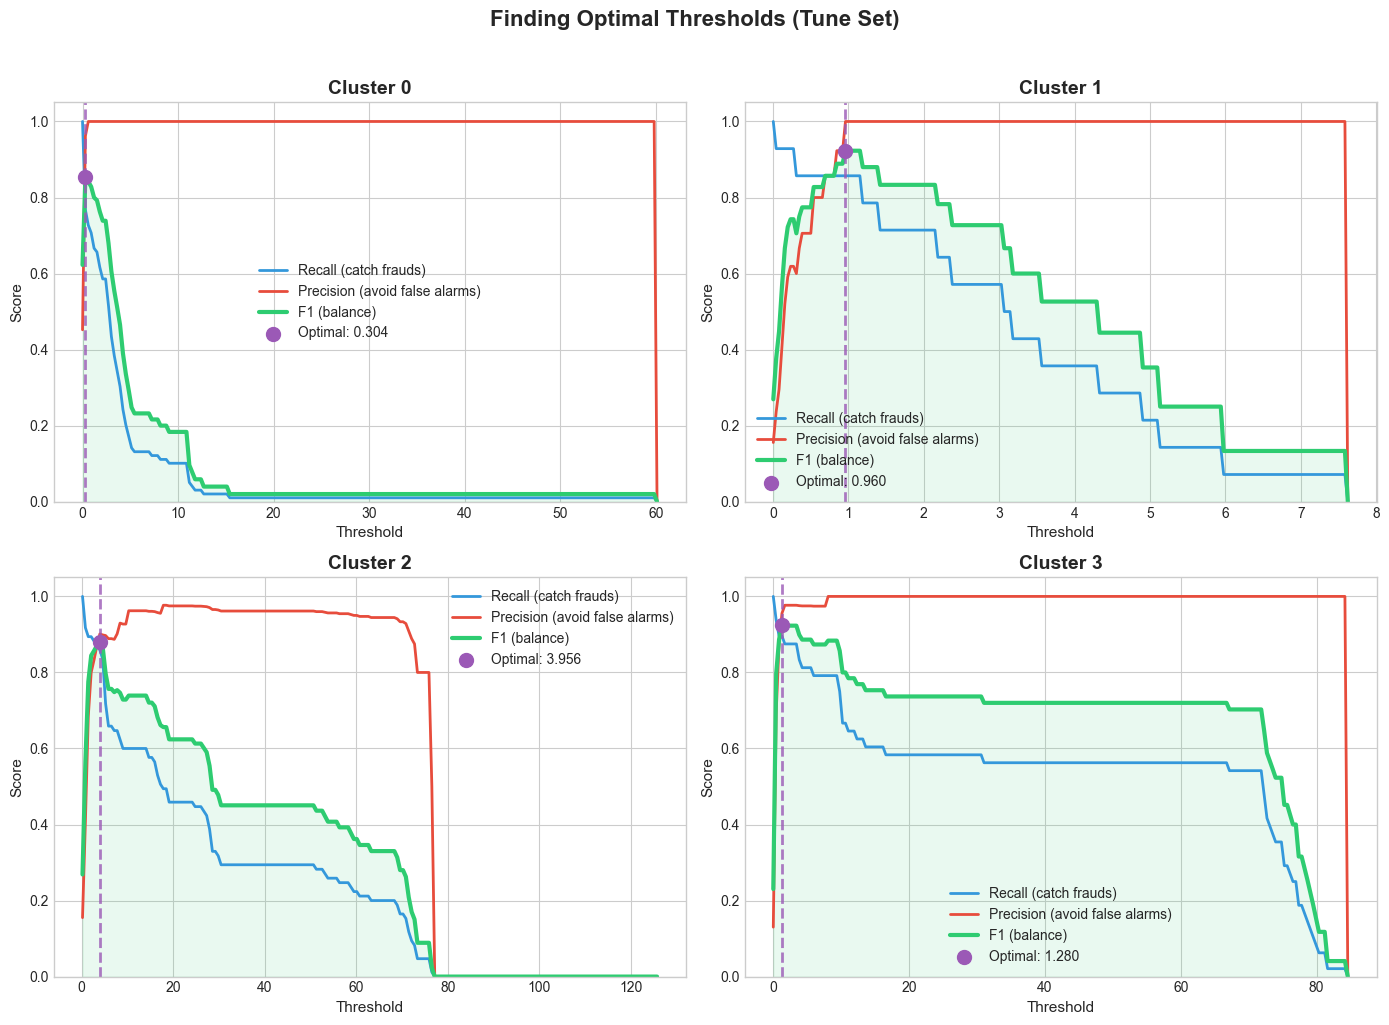

In [7]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = {'recall': '#3498db', 'precision': '#e74c3c', 'f1': '#2ecc71', 'optimal': '#9b59b6'}

for cluster_id, ax in enumerate(axes.flatten()):
    results_df = threshold_results[cluster_id]

    ax.plot(results_df['threshold'], results_df['recall'], label='Recall (catch frauds)', color=colors['recall'], linewidth=2)
    ax.plot(results_df['threshold'], results_df['precision'], label='Precision (avoid false alarms)', color=colors['precision'], linewidth=2)
    ax.plot(results_df['threshold'], results_df['f1'], label='F1 (balance)', color=colors['f1'], linewidth=3)

    best_thresh = optimal_thresholds[cluster_id]
    best_f1 = results_df.loc[results_df['f1'].idxmax(), 'f1']
    ax.axvline(best_thresh, color=colors['optimal'], linestyle='--', linewidth=2, alpha=0.8)
    ax.scatter([best_thresh], [best_f1], color=colors['optimal'], s=100, zorder=5,label=f'Optimal: {best_thresh:.3f}')
    ax.set_title(f'Cluster {cluster_id}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Threshold', fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_ylim([0, 1.05])
    ax.legend(loc='best', framealpha=0.9)
    ax.fill_between(results_df['threshold'], results_df['f1'], alpha=0.1, color=colors['f1'])

plt.suptitle('Finding Optimal Thresholds (Tune Set)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

 ## 5. Error Distributions

  These histograms show the reconstruction error distributions for normal (blue) and fraud (red) transactions.

  - **Good separation**: Blue and red don't overlap much → easy to find a threshold
  - **Poor separation**: Significant overlap → harder to distinguish fraud from normal

  The green line shows our chosen threshold (everything left of the threshold marked as non-fraud, right of threshold marked as fraud).

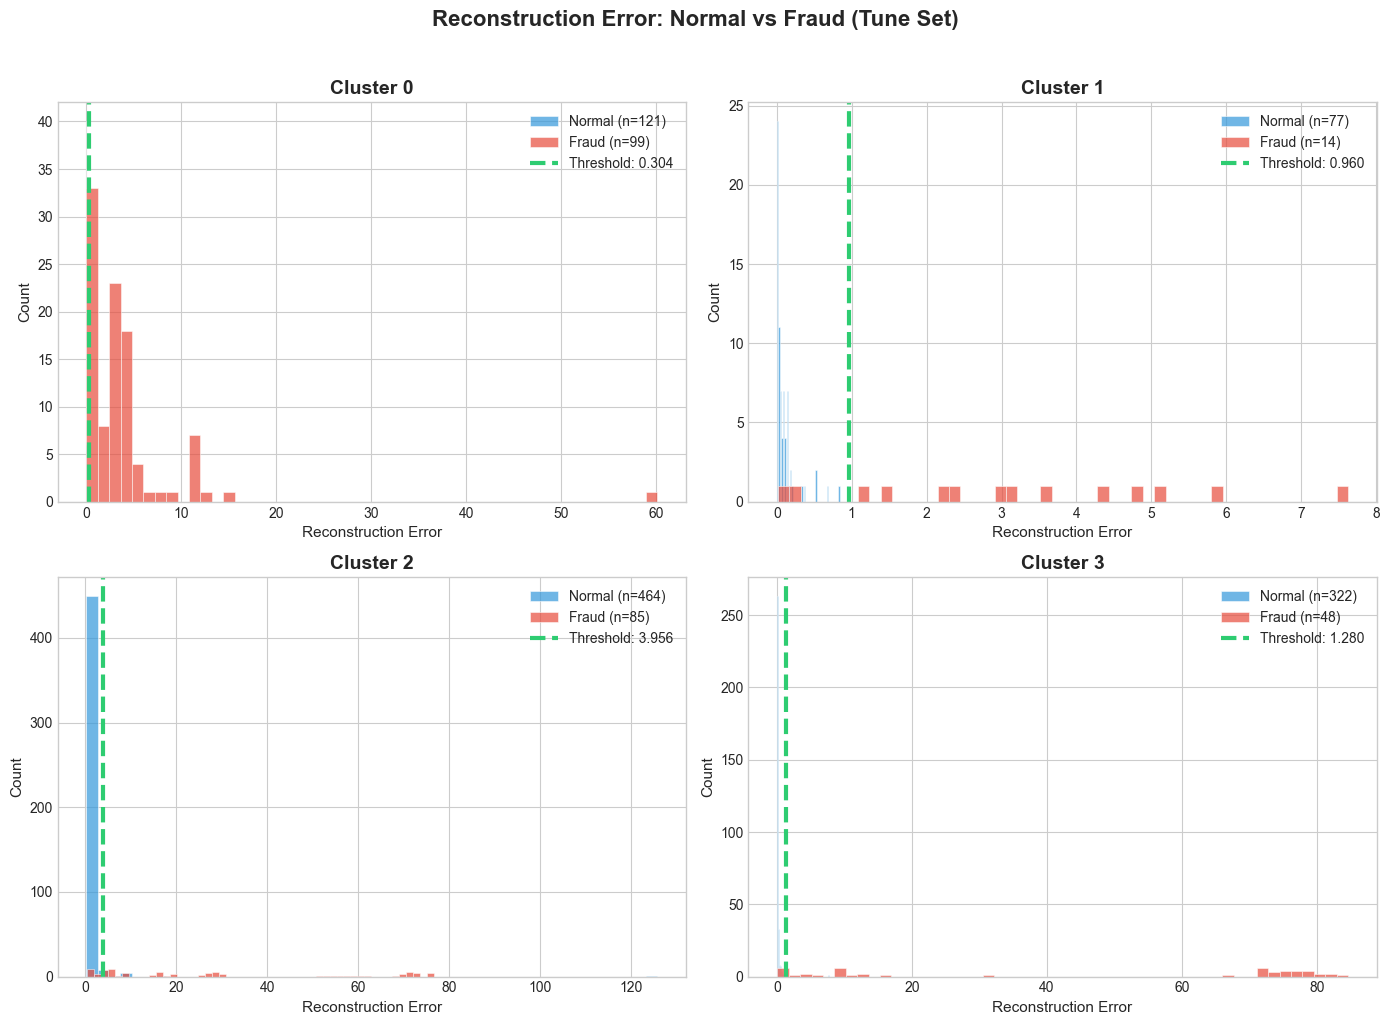

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for cluster_id, ax in enumerate(axes.flatten()):
    errors = cluster_data_tune[cluster_id]['errors']
    labels = cluster_data_tune[cluster_id]['labels']

    normal_errors = errors[labels == 0]
    fraud_errors = errors[labels == 1]

    ax.hist(normal_errors, bins=50, alpha=0.7, label=f'Normal (n={len(normal_errors)})',
            color='#3498db', edgecolor='white', linewidth=0.5)
    ax.hist(fraud_errors, bins=50, alpha=0.7, label=f'Fraud (n={len(fraud_errors)})',
            color='#e74c3c', edgecolor='white', linewidth=0.5)

    thresh = optimal_thresholds[cluster_id]
    ax.axvline(thresh, color='#2ecc71', linestyle='--', linewidth=3,
                label=f'Threshold: {thresh:.3f}')

    ax.set_title(f'Cluster {cluster_id}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Reconstruction Error', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.legend(loc='upper right', framealpha=0.9)

plt.suptitle('Reconstruction Error: Normal vs Fraud (Tune Set)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Evaluation on (untouched) test set

  Now we apply the thresholds (found on the tune set) to the test set. We calculate the errors to evaluate the performance.

  ### 6.1 Per-Cluster Results

  For each cluster, we:
  1. Compute reconstruction errors using that cluster's AutoEncoder
  2. Apply the threshold we found earlier
  3. Compare predictions to actual labels

In [ ]:
cluster_data_test = {}

for cluster_id in range(4):
    mask = (cluster_labels_test == cluster_id)
    X_cluster = X_test_scaled[mask]
    y_cluster = y_test[mask]

    model = AutoEncoder.from_pretrained(cluster_id, models_dir='../models')
    errors = compute_reconstruction_errors(model, X_cluster)

    cluster_data_test[cluster_id] = {
        'errors': errors,
        'labels': y_cluster,
        'mask': mask
    }

y_pred_test = np.zeros_like(y_test)

for cluster_id in range(4):
    errors = cluster_data_test[cluster_id]['errors']
    labels = cluster_data_test[cluster_id]['labels']
    mask = cluster_data_test[cluster_id]['mask']
    threshold = optimal_thresholds[cluster_id]

    predictions = (errors > threshold).astype(int)
    y_pred_test[mask] = predictions

    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions, zero_division=0)
    rec = recall_score(labels, predictions, zero_division=0)
    f1 = f1_score(labels, predictions, zero_division=0)

    print(f"\nCluster {cluster_id} (threshold={threshold:.4f}, n={len(labels)})")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1:        {f1:.4f}")


Cluster 0 (threshold=0.3039, n=222)
  Accuracy:  0.8559
  Precision: 0.8511
  Recall:    0.8163
  F1:        0.8333

Cluster 1 (threshold=0.9604, n=89)
  Accuracy:  0.9326
  Precision: 0.9167
  Recall:    0.8462
  F1:        0.8800

Cluster 2 (threshold=3.9564, n=571)
  Accuracy:  0.9650
  Precision: 0.9079
  Recall:    0.8415
  F1:        0.8734

Cluster 3 (threshold=1.2800, n=348)
  Accuracy:  0.9741
  Precision: 0.9189
  Recall:    0.8500
  F1:        0.8831


 ### 6.2 Overall Results

  Now we combine predictions from all clusters to see total system performance.

In [29]:
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, zero_division=0)
rec = recall_score(y_test, y_pred_test, zero_division=0)
f1 = f1_score(y_test, y_pred_test, zero_division=0)
cm = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1:         {f1:.4f}")

Accuracy:   0.9455
Precision:  0.8874
Recall:     0.8333
F1:         0.8595


## 7. Confusion Matrix (getum tekið út en kannski næs fyrir reportið)

  The confusion matrix (2x2 með [TN, FP; FN, TP]) shows all prediction outcomes:
  |  | Predicted Normal | Predicted Fraud |
  |--|------------------|-----------------|
  | **Actually Normal** | True Negative (correct) | False Positive (false alarm) |
  | **Actually Fraud** | False Negative (missed) | True Positive (caught) |

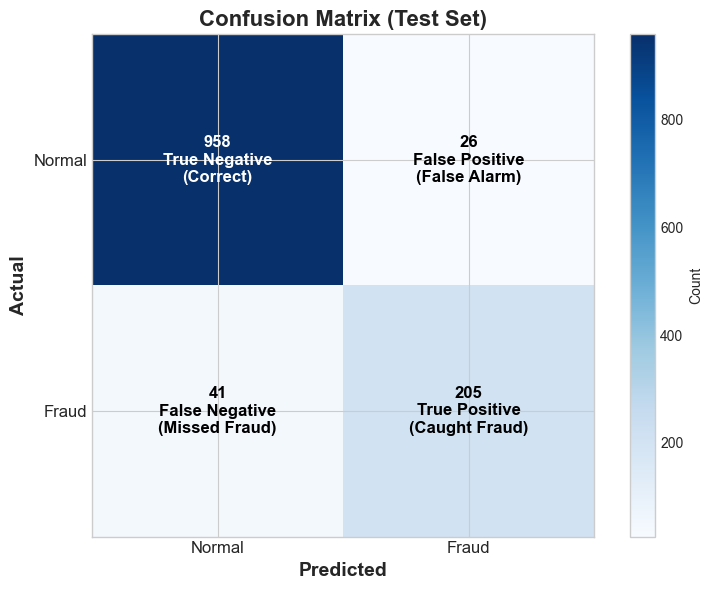

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
labels = [['True Negative\n(Correct)', 'False Positive\n(False Alarm)'],
        ['False Negative\n(Missed Fraud)', 'True Positive\n(Caught Fraud)']]

for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max()/2 else 'black'
        ax.text(j, i, f'{cm[i, j]}\n{labels[i][j]}', ha='center', va='center', fontsize=12, color=color, fontweight='bold')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Normal', 'Fraud'], fontsize=12)
ax.set_yticklabels(['Normal', 'Fraud'], fontsize=12)
ax.set_xlabel('Predicted', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=14, fontweight='bold')
ax.set_title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')

plt.colorbar(im, ax=ax, label='Count')
plt.tight_layout()
plt.show()

## 8. Summary

  Final optimized thresholds and performance metrics on the test set.

In [27]:
print(f"\nOptimal thresholds (found on tune set):")
for i, thresh in enumerate(optimal_thresholds):
    print(f"  Cluster {i}: {thresh:.6f}")

print(f"\nFinal metrics over all clusters (evaluated on test set):")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1:        {f1:.4f}")


Optimal thresholds (found on tune set):
  Cluster 0: 0.303904
  Cluster 1: 0.960444
  Cluster 2: 3.956400
  Cluster 3: 1.279988

Final metrics over all clusters (evaluated on test set):
  Accuracy:  0.9455
  Precision: 0.8874
  Recall:    0.8333
  F1:        0.8595
